In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import os
import datetime as dt
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

%config IPCompleter.greedy=True

In [4]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Table of Contents

   * [Data Loading](#data_load)
   * [Feature Importance](#random_forest)

## Data loading <a class="anchor" id="data_load"></a>

Importing file from where we left off after EDA.

In [3]:
df3 = pd.read_csv('../notebooks/df3.csv')

In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14482 entries, 0 to 14481
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     14482 non-null  object 
 1   region                      14482 non-null  object 
 2   year                        14482 non-null  int64  
 3   startmonth                  14482 non-null  float64
 4   participants_int            14465 non-null  float64
 5   new_participants_category   14465 non-null  object 
 6   labor_wage_dispute          14482 non-null  bool   
 7   land_farm_issue             14482 non-null  bool   
 8   police_brutality            14482 non-null  bool   
 9   political_behavior          14482 non-null  bool   
 10  price_increases_tax_policy  14482 non-null  bool   
 11  removal_of_politician       14482 non-null  bool   
 12  social_restrictions         14482 non-null  bool   
 13  protesterdemand1_y          144

In [6]:
df_target = df3[['Violent_Response']]

In [7]:
df_target.head()

,Violent_Response
0,False
1,False
2,False
3,False
4,False


In [8]:
#dropping "duplicate" columns that are represented elsewhere in the df, as well as any target data and "future" data
df3.drop(columns=['participants_int','protesterdemand1_y','protesterdemand2_y','protesterdemand3_y','protesterdemand4_y','stateresponse1_y','stateresponse2_y','stateresponse3_y','stateresponse4_y','stateresponse5_y','stateresponse6_y','stateresponse7_y', 'start_date','end_date','Violent_Response','accomodation','arrests','beatings','crowd_dispersal','ignore','killings','shootings','first_response','last_response', 'responses_count','protesterviolence','dur_column','dur_column2' ] , inplace=True)

In [9]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14482 entries, 0 to 14481
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     14482 non-null  object 
 1   region                      14482 non-null  object 
 2   year                        14482 non-null  int64  
 3   startmonth                  14482 non-null  float64
 4   new_participants_category   14465 non-null  object 
 5   labor_wage_dispute          14482 non-null  bool   
 6   land_farm_issue             14482 non-null  bool   
 7   police_brutality            14482 non-null  bool   
 8   political_behavior          14482 non-null  bool   
 9   price_increases_tax_policy  14482 non-null  bool   
 10  removal_of_politician       14482 non-null  bool   
 11  social_restrictions         14482 non-null  bool   
 12  demands_count               14482 non-null  int64  
 13  hemisphere                  144

In [10]:
#Creating new df with dummy columns
df_encoded = pd.get_dummies(df3, columns=None)

In [11]:
df_encoded

,year,startmonth,labor_wage_dispute,land_farm_issue,police_brutality,political_behavior,price_increases_tax_policy,removal_of_politician,social_restrictions,demands_count,...,new_participants_category_2000-4999,new_participants_category_50-99,new_participants_category_5000-10000,new_participants_category_>10000,hemisphere_northern,hemisphere_southern,season_autumn,season_spring,season_summer,season_winter
0,1990,1.0,True,False,False,True,False,False,False,2,...,0,0,0,0,1,0,0,0,0,1
1,1990,6.0,False,False,False,True,False,False,False,1,...,0,0,0,0,1,0,0,0,1,0
2,1990,7.0,False,False,False,True,False,False,False,1,...,0,0,0,0,1,0,0,0,1,0
3,1990,7.0,False,True,False,False,False,False,False,1,...,0,0,0,0,1,0,0,0,1,0
4,1990,8.0,False,False,False,True,False,False,False,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14477,2014,2.0,False,False,False,True,False,False,False,1,...,0,0,0,0,0,1,0,0,1,0
14478,2016,5.0,False,False,False,False,False,True,False,1,...,0,0,0,0,0,1,1,0,0,0
14479,2017,6.0,False,True,False,True,False,False,False,2,...,0,1,0,0,0,1,0,0,0,1
14480,2017,7.0,False,False,False,True,False,False,False,1,...,0,1,0,0,0,1,0,0,0,1


In [12]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14482 entries, 0 to 14481
Columns: 197 entries, year to season_winter
dtypes: bool(7), float64(1), int64(2), uint8(187)
memory usage: 3.0 MB


In [13]:
df_encoded.columns

Index(['year', 'startmonth', 'labor_wage_dispute', 'land_farm_issue',
       'police_brutality', 'political_behavior', 'price_increases_tax_policy',
       'removal_of_politician', 'social_restrictions', 'demands_count',
       ...
       'new_participants_category_2000-4999',
       'new_participants_category_50-99',
       'new_participants_category_5000-10000',
       'new_participants_category_>10000', 'hemisphere_northern',
       'hemisphere_southern', 'season_autumn', 'season_spring',
       'season_summer', 'season_winter'],
      dtype='object', length=197)

In [14]:
df_encoded.to_csv('df_encoded.csv', index=False)

## Feature Importance <a class="anchor" id="random_forest"></a>

In [15]:
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [16]:
X = pd.DataFrame(df_encoded, columns=df_encoded.columns)
y = np.ravel(df_target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [17]:
rf = RandomForestRegressor(n_estimators=300)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300)

In [18]:
list_of_tuples = list(zip(df_encoded.columns, rf.feature_importances_)) 

In [19]:
df_rf = pd.DataFrame(list_of_tuples, columns = ['feature', 'importance']) 

In [20]:
sorted_feat20 = df_rf.nlargest(20,'importance')

In [21]:
sorted_feat20.head()

,feature,importance
0,year,0.199293
1,startmonth,0.132511
185,new_participants_category_100-999,0.038543
179,region_Europe,0.033443
5,political_behavior,0.026650


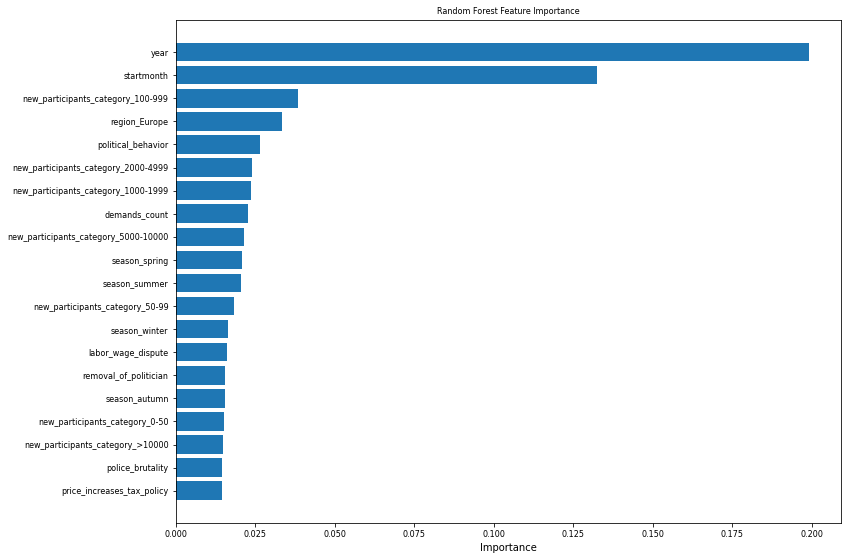

In [22]:
plt.barh('feature','importance',data=sorted_feat20)
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
#plt.savefig('15_Feature_Importance.png')

In [23]:
sorted_feat50 = df_rf.nlargest(50,'importance')

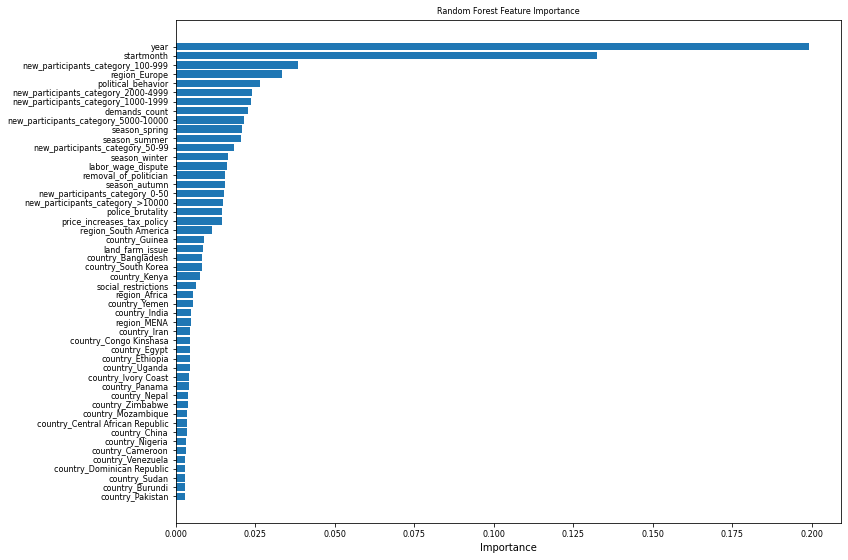

In [24]:
plt.barh('feature','importance',data=sorted_feat50)
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
#plt.savefig('15b_Feature_Importance.png')